### Install packages

In [1]:
# work with data
import numpy as np
import pandas as pd
import h5pyd

# work with geospatial
import geopandas as gpd
from scipy.interpolate import griddata
from pyproj import Proj, Transformer
from scipy.spatial import cKDTree

# optimization
import gurobipy as gp
from gurobipy import GRB

# visualization
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


# work with time
import pytz

### Get geometries

In [2]:
# Arizona shapefile

us_states = gpd.read_file('/Users/richy/Downloads/Classes/Spring_2025/1.020/Project/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
arizona = us_states[us_states['NAME'] == 'Arizona']
arizona.to_crs("EPSG:5070", inplace=True) # we use EPSG 5070 to get more accurate area measurements. https://epsg.io/5070-1252

# water basins shapefile

huc_subbasins = gpd.read_file('/Users/richy/Downloads/Classes/Spring_2025/1.020/Project/HUC8_CONUS/HUC8_US.shp') # read in subbasins
huc_subbasins['has_arizona'] = huc_subbasins['STATES'].map(lambda x: 'AZ' in x)
huc_subbasins_az = huc_subbasins[huc_subbasins['has_arizona']]
huc_subbasins_az.to_crs("EPSG:5070", inplace=True)

huc_subbasins_az['HUC6'] = huc_subbasins_az['HUC8'].map(lambda x: x[:6])

# also, in case we want centroid:
huc_subbasins_az['centroid'] = huc_subbasins_az.to_crs("+proj=cea").centroid.to_crs(huc_subbasins_az.crs)

# transform centroid to lat and lon
transformer = Transformer.from_crs(5070, 4326)

huc_subbasins_az['centroid_lat_lon'] = huc_subbasins_az['centroid'].map(lambda pt: transformer.transform(pt.x, pt.y))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarni

### Solar Data Collection

In [4]:
# access NSRDB stuff: https://github.com/NREL/hsds-examples/tree/master

# takes around a minute to run 

solar = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2020.h5")
meta = pd.DataFrame(solar['meta'][...])

In [4]:
# find the nearest timeseries

dset_coords = solar['coordinates'][...]
tree = cKDTree(dset_coords)

def nearest_site(tree, lat_coord, lon_coord):
    """ 
    Find the nearest site in the dataset.

    Parameters
    ----------
        tree: scipy.spatial.cKDTree
            Lookup tree for nearest neighbor
        lat_coord: float
            Latitude
        lon_coord: float
            Longitude
    """

    lat_lon = np.array([lat_coord, lon_coord])
    dist, pos = tree.query(lat_lon)
    return pos

In [ ]:
def shift_from_utc(data, offset_hours, time_gap):
    """
    Shift hourly values from UTC to a timezone that is `offset_hours`
    behind UTC.

    Parameters
    ----------
        data: np.ndarray
            Array of data
        offset_hours: int
            Number of hours to offset
        time_gap: float
            Time gap between subsequent data points
    """

    # roll left by offset_hours:
    hour_multiplier = 1/time_gap
    shift_idx = int(offset_hours * hour_multiplier)

    return np.concatenate([data[shift_idx:], data[:shift_idx]], axis=0)

In [ ]:
# collect GHI at every point

ghi_data = solar['ghi']

ghi_subbasins = np.zeros((ghi_data.shape[0], huc_subbasins_az.shape[0])) # rows: timestamps, # columns: locations

# for each arizona subbasin centroid, get the solar data of the closest point
for idx, centroid in enumerate(huc_subbasins_az['centroid']):
    
    centroid_idx = nearest_site(tree, centroid_lat, centroid_lon)
    ghi_tseries = ghi_data[:, centroid_idx] / ghi_data.attrs['psm_scale_factor'] # units: W/m^2. https://nsrdb.nrel.gov/data-sets/us-data

    ghi_subbasins[:, idx] = ghi_tseries

ghi_subbasins = shift_from_utc(ghi_subbasins, 7, 0.5) # shift to Arizona time. 7 hours delay

In [69]:
# timestamp

# convert timestamps from UTC to Arizona time: https://www.geeksforgeeks.org/how-to-convert-date-and-time-with-different-timezones-in-python/
AZ_time = pytz.timezone('America/Phoenix')

time_index = pd.to_datetime(solar['time_index'][...].astype(str))
time_index = time_index.map(lambda x: x.astimezone(AZ_time)) # in UTC
time_index = shift_from_utc(time_index, 7, 0.5)

In [ ]:
# and then aggregate the GHI values into days
ghi_subbasins = ghi_subbasins.reshape((ghi_data.shape[0]//48, 48, huc_subbasins_az.shape[0])) # note grouping by 48, because we are in half hour intervals

ghi_subbasins = ghi_subbasins.sum(axis=1) # W/(m^2 * day)

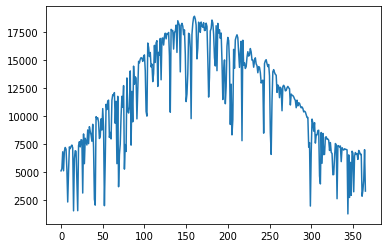

In [85]:
plt.plot(ghi_subbasins[:, 0])

In [ ]:
# solar capacity computation: oof I will do this later. just assume 21% efficiency for now. https://css.umich.edu/publications/factsheets/energy/solar-pv-energy-factsheet#:~:text=Solar%20Resources%20and%20Potential&text=PV%20conversion%20efficiency%20is%20the,that%20is%20converted%20to%20electricity.&text=Though%20the%20average%20efficiency%20of,with%20efficiencies%20near%2040%259.

# solar panel price: $2.06/W, https://www.energysage.com/local-data/solar-panel-cost/az/
# and 200 W/m^2 https://www.sunstyle.com/portfolio/square-meter-solar-family-need/#:~:text=The%20efficiency%20of%20solar%20panels,value%20of%20175%20Wp%2Fm%C2%B2.
# so, we get $412/m^2.



In [ ]:
# lets try this wind turbine model GE1.5, just out of commonality. https://en.wind-turbine-models.com/turbines/565-ge-vernova-ge-1.5s
# lets say 77m height
# and 80m diameter --> regime is around 42m to 112m
# so let's take windspeed at 77m

wind = h5pyd.File("/nrel/wtk-us.h5")

wind_speed = wind['windspeed_80m']


# rated power
GE_power_curve = pd.read_csv('/Users/richy/Downloads/Classes/Spring_2025/1.020/Project/DOE_GE_1.5MW_77.csv')

In [ ]:
# get wind speeds at closest location for each of the Arizona subbasins

wind_dict = {}

In [ ]:
# wind calculations:
# price: let's say $1500/kW --> $1,500,000/MW. https://www.energy.gov/eere/wind/articles/land-based-wind-market-report-2022-edition

In [3]:
# get lists of HUC8 subbasins that group into HUC6 basins
huc6_huc8_dict = dict()

for huc6 in huc_subbasins_az['HUC6'].unique():
    huc_filter = huc_subbasins_az[huc_subbasins_az['HUC6'] == huc6]
    huc6_huc8_dict[huc6] = huc_filter['HUC8'].to_list()

# data values for HUC8 regions generated from the paper by Abu Bakar Siddik et al 2021: https://iopscience.iop.org/article/10.1088/1748-9326/abfba1?_sp=b48260d8-0a7b-4784-9d4b-0e1ac60ee727
water_carbon = pd.read_excel("/Users/richy/Downloads/Classes/Spring_2025/1.020/Project/DC_footprint/SI_XLS/Results.xlsx", sheet_name="Table 3", skiprows=1)

water_carbon['HUC8_str'] = water_carbon['HUC8'].map(lambda x: ''.join(['0']*(8-len(str(x)))) + str(x))

# filter to only HUC rows
water_carbon['not_nan'] = ~water_carbon['WSF_1MW_DC'].isna()
water_carbon = water_carbon[water_carbon['not_nan']]

# now merge with the arizona HUC data
huc_subbasins_az = huc_subbasins_az.merge(water_carbon, how="inner", left_on="HUC8", right_on="HUC8_str")
huc_subbasins_az = gpd.clip(huc_subbasins_az, arizona)

In [4]:
# estimations of existing data centers: https://www.datacentermap.com/
# power of existing data centers? Unclear. https://baxtel.com/data-center/phoenix
# well, in total there is around 602.8 MW in the Phoenix area. https://azbigmedia.com/real-estate/phoenix-ranks-4th-among-north-american-data-center-markets/
# and, in the Phoenix area there are 124 data centers. https://www.datacentermap.com/usa/arizona/
# so, let's say on average, each existing data center takes on 5 MW of load.

# existing inventory HUC8
# 15050301: 6
# 15050302: 2
# 15050303: 4 (from Eloy) 
# 15050100: 17 (from Mesa airport AZA) 13 (from Chandler airport CHD) 4 (from Gilbert)
# 15060106: 2 (from Mesa) 25 (from Phoenix airport and Scottsdale) 2 (from upper Scottsdale)
# 15070102: 6 (from Deer Valley) 40 (from Litchfield park airport)
# 15070103: 1 (from Buckeye/Arlington)


# totals (done by hand, because data lies behind paywalls):
# 15050301: 6
# 15050302: 2
# 15050303: 4
# 15050100: 34
# 15060106: 29
# 15070102: 46
# 15070103: 1

existing_data_centers = {
    15050301: 6,
    15050302: 2,
    15050303: 4,
    15050100: 34,
    15060106: 29,
    15070102: 46,
    15070103: 1
}

huc_subbasins_az['existing_MW'] = huc_subbasins_az['HUC8_y'].map(lambda x: existing_data_centers.get(x, 0)*5)

In [5]:
# read in US counties
us_counties = gpd.read_file('/Users/richy/Downloads/Classes/Spring_2025/1.020/Project/cb_2018_us_county_500k/cb_2018_us_county_500k.shp') # read in counties
arizona_counties = us_counties[us_counties['STATEFP'] == '04'] # filter to arizona
arizona_counties.to_crs("EPSG:5070", inplace=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [6]:
# electricity prices
# https://www.energysage.com/local-data/electricity-cost/az/
# cochise county: 16 cents/kwh
# coconino county: 15 cents/kwh
# gila county: 20 cents/kwh
# la paz county: 15 cents/kwh
# maricopa county: 15 cents/kwh
# mohave county: 18 cents/kwh
# navajo county: 15 cents/kwh
# pima county: 18 cents/kwh
# pinal county: 16 cents/kwh
# yavapai county: 15 cents/kwh
# yuma county: 15 cents/kwh

# units: cents/kwh
elec_price_dict = {'Cochise': 16, 'Coconino': 15, 'Gila': 20, 'La Paz': 15, 'Maricopa': 15, 'Mohave': 18, 
                   'Navajo': 15, 'Pima': 18, 'Pinal': 16, 'Yavapai': 15, 'Yuma': 15}

# new units: dollars/mw = cents/kwh * (0.01 dollar/1 cent) * (1000 kwh/1 mw)
elec_price_dict = {k: 10*v for k, v in elec_price_dict.items()}

has_elec_price = set(elec_price_dict.keys())
num_elec_price = len(has_elec_price)

# find arizona counties with electricity price data
arizona_counties['has_elec_price'] = arizona_counties['NAME'].map(lambda x: x in has_elec_price)
arizona_counties_elec_price = arizona_counties[arizona_counties['has_elec_price']]
arizona_counties_elec_price['elec_price'] = arizona_counties_elec_price['NAME'].map(lambda x: elec_price_dict[x])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [7]:
# TODO move to a Python utils file

class resolve_regions:
    """ 
    Converts one subdivision of space (e.g., county) into another subdivision of space (e.g., HUC8.)

    Averages out value of interest according to amount of overlap with the first subdivision of space, or the 
    closest region. 
    """

    def __init__(self, from_df, to_df, value_col, id_row):
        """ 
        Init method for the class resolve_regions.

        Parameters
        ----------
            from_df: gpd.GeoDataFrame
                Dataframe to convert from
            to_df: gpd.GeoDataFrame
                Dataframe to convert to
            value_col: string
                Name of column with values of interest
            id_row: string
                Name of column with unique identifiers, in to_df
        """

        self.from_df = from_df
        self.to_df = to_df
        self.value_col = value_col
        self.id_row = id_row

# TODO: currently this only handles average. We can also functionalize it to handle other functions.
    def weighted_computation(self, id):
        """ 
        Perform the weighted average computation for the output row with identification id.

        Parameters
        ----------
            id: string
                Unique ID for the output row
        """

        to_geometry = self.to_df[self.to_df[self.id_row] == id]['geometry'].iloc[0] # extract geometry of to_df
        from_to_intersect = self.from_df['geometry'].intersection(to_geometry) # obtain intersections

        area_sum = np.sum(from_to_intersect.area)

        if area_sum > 0: # some intersection
            weighted_val = 0 # keep track of weighted sum for value of interest

            for idx, area in from_to_intersect.area.items():
                weighted_val += self.from_df.loc[idx, self.value_col]*area
            
            weighted_val /= area_sum
        
        else:
            from_to_distance = self.from_df['geometry'].distance(to_geometry) # obtain distances
            from_to_distance.sort_values(ascending=True, inplace=True)
            lowest_idx = from_to_distance.index[0]

            weighted_val = self.from_df.loc[lowest_idx, self.value_col]

        return weighted_val

    def convert_regions(self):
        """ 
        Perform conversion between the subdivisions of space, and average the value of interest.
        """

        converted_value_list = []

        for id in self.to_df[self.id_row]: # iterate over geometries of to_df
            converted_value_list.append(self.weighted_computation(id))

        self.to_df[self.value_col] = converted_value_list # set the output values after conversion

In [8]:
# assign electricity price in HUC8 regions to closest county with price
# consider: if desired, we can add some random noise

# build up the elec_price ($/MW) column

county_to_huc_elec_price = resolve_regions(arizona_counties_elec_price, huc_subbasins_az, 'elec_price', 'HUC8_y')
county_to_huc_elec_price.convert_regions()

In [9]:
# next, let's take a look at land prices. 
# we get TIF files from here: https://www.pnas.org/doi/10.1073/pnas.2012865117. Units: log(2017$/hectare)
# first, let's convert into linear units.

from osgeo import gdal

import rasterio

# perhaps we can use this for modifying the tif file: https://github.com/rasterio/rasterio/discussions/3006

if False: # only need to do this once
    # convert $/hectare to $/acre
    acre_to_hectare = 2.47105

    # original data is in ln(2017$/hectare). Transform to linear scaling
    land_vacant = rasterio.open('/Users/richy/Downloads/Classes/Spring_2025/1.020/Project/doi_10_5061_dryad_np5hqbzq9__v20201008/places_fmv_pnas_dryad/1 estimates/places_fmv_vacant.tif')
    land_data_np = land_vacant.read(1)
    land_vacant.close()

    land_data_np = np.where(land_data_np != 0, np.exp(land_data_np), 0) # transform the data to 2017$/hectare
    land_data_np = land_data_np/acre_to_hectare # transform the data to 2017$/acre

    # save back to tif
    with rasterio.open('/Users/richy/Downloads/Classes/Spring_2025/1.020/Project/doi_10_5061_dryad_np5hqbzq9__v20201008/places_fmv_pnas_dryad/1 estimates/land_cost_linear.tif', 'r+') as f:
        f.write(land_data_np, indexes=1)

    f.close()

In [10]:
# now, we resample the raster first to avoid high compute times: Raster > Projections > Warp (Reproject). We resample using median, so that we can account for/ignore outliers: really expensive pieces of land (ex. Manhattan).
# we then convert raster to polygon using QGIS. Raster > Conversion > Polygonize (Raster to Vector)

# import the converted polygon file
land_costs_shp = gpd.read_file('/Users/richy/Downloads/Classes/Spring_2025/1.020/Project/doi_10_5061_dryad_np5hqbzq9__v20201008/places_fmv_pnas_dryad/1 estimates/land_cost_linear_10000x10000.shp')
land_costs_shp.to_crs('EPSG:5070', inplace=True)
land_costs_shp_az = land_costs_shp[land_costs_shp.intersects(arizona.iloc[0,-1])]

# NOTE: to increase accuracy, make sure to account for public land and Native American land. https://www.pnas.org/doi/10.1073/pnas.2012865117

In [11]:
# compute estimated land costs in each HUC8
# takes around 40 seconds to run. if desired, can even upscale the resolution further (to 20000x20000?)
pixel_to_huc_land_cost = resolve_regions(land_costs_shp, huc_subbasins_az, 'DN', 'HUC8_y')
pixel_to_huc_land_cost.convert_regions()

In [ ]:
# requirement for acres of land: https://www.jll.com/en-us/insights/how-to-assess-a-propertys-data-center-potential#:~:text=Data%20centers%20built%20for%20AI,multiple%20power%20substations%20on%20site.
# lets say 1 GW = 1000MW requires 500 acres. So each MW requires 0.5 acres.

# let's say data centers have a lifespan of 20 years: https://www.datacenterdynamics.com/en/analysis/the-data-center-life-story/.

# time to convert everything to the right units...

# WSF_1MW_DC: (m^3-eq water/MWh) * (24h/day) * (365.25day/year) * 20 year * 1MW = 24 * 365.25 * 20 multiplying factor
# CF_1MW_DC: (kg-eq CO2/MWh) * (24h/day) * (365.25day/year) * 20 year * 1MW = 24 * 365.25 * 20 multiplying factor
# elec_price: ($/MWh) * (24h/day) * (365.25day/year) * 20 year * 1MW = 24 * 365.25 * 20 multiplying factor
# land price: ($/acre) * (0.5acre/MW) * 1 MW = 0.5 multiplying factor

In [12]:
hours_multiplying = 24 * 365.25 * 20 # hours/day * days/year * years lifespan
land_multiplying = 0.5 # 0.5 acre/MW

# huc_subbasins_az['WSF_1MW_DC'] = huc_subbasins_az['WSF_1MW_DC'] * hours_multiplying # we could do this for water stress factor and carbon factor, but no need technically
# huc_subbasins_az['CF_1MW_DC'] = huc_subbasins_az['CF_1MW_DC'] * hours_multiplying
huc_subbasins_az['elec_price'] = huc_subbasins_az['elec_price'] * hours_multiplying
huc_subbasins_az['DN'] = huc_subbasins_az['DN'] * land_multiplying

huc_subbasins_az['tot_price'] = huc_subbasins_az['elec_price'] + huc_subbasins_az['DN']

In [13]:
# take a look at water stress factor, carbon factor data
# wsf_dict = {k: v for k, v in zip(huc_subbasins_az['HUC8_y'], huc_subbasins_az['WSF_1MW_DC'])}
# cf_dict = {k: v for k, v in zip(huc_subbasins_az['HUC8_y'], huc_subbasins_az['CF_1MW_DC'])}

s_max = huc_subbasins_az['WSF_1MW_DC'].max()
eplp_max = huc_subbasins_az['tot_price'].max()
e_max = huc_subbasins_az['CF_1MW_DC'].max()

In [14]:
# normalize variables

huc_subbasins_az['WSF_1MW_DC_normalize'] = huc_subbasins_az['WSF_1MW_DC']/s_max
huc_subbasins_az['tot_price_normalize'] = huc_subbasins_az['tot_price']/eplp_max
huc_subbasins_az['CF_1MW_DC_normalize'] = huc_subbasins_az['CF_1MW_DC']/e_max

In [ ]:
# functionalize visualization of different statistics

def visualize_stats(df, col, title, cmap, cmap_label, ax=None):
    """ 
    Visualization of selected statistics on HUC8 subbasins.

    Parameters
    ----------
        df: geopandas.GeoDataFrame
            GeoDataFrame to visualize
        col: column 
            Column of GeoDataFrame for colors
        title: string
            Title of map
        cmap: string
            Color map to use
        cmap_label: string
            Label of color bar
        ax: matplotlib.axes.Axes
            Axis to plot the map on.

    Returns
    -------
        ax: matplotlib.axes.Axes
            Axis with the plotted figure
    """

    _ = df.plot(column=col, cmap=cmap, legend=True, legend_kwds={"label": cmap_label})

    ax.set_title(title)

    return ax

<AxesSubplot:>

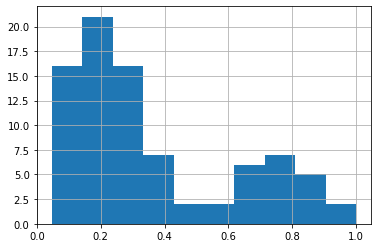

In [ ]:
# visualize 
huc_subbasins_az['WSF_1MW_DC_normalize'].hist()

In [ ]:
# huc8 list
huc8_iter = huc_subbasins_az['HUC8_y']

# set index for dataframe
huc_subbasins_az.set_index(huc8_iter, inplace=True)

# implement optimization model

# number of MW required to add
add_req = 100

# weights for the objective function
weights = {
    'WSF_1MW_DC_normalize': 1, # because we normalize our values, which I think makes sense, we should inflate this more; there is more variation in WSF than land price, for example, which makes land price more consequential if we did comparable scaling factors. I guess that's a design choice.
    'tot_price_normalize': 0.1,
    'CF_1MW_DC_normalize': 0.1
}

# normalization, maximum values
max_vals = {
    'WSF_1MW_DC_normalize': s_max,
    'tot_price_normalize': eplp_max,
    'CF_1MW_DC_normalize': e_max
}

model = gp.Model("AddDataCenters")

# decision variables: amount of MW to put in each HUC8 subbasin
x = dict()

for huc8_code in huc8_iter:
    x[huc8_code] = model.addVar(lb=0, name=f"x_{huc8_code}")

# another decision variable: maximum water stress in any subbasin
basin_max = model.addVar(lb=0, name="basin_max")

# develop objective
obj = gp.LinExpr()

for huc8_code in huc8_iter:
    for key in weights.keys():
        obj += x[huc8_code]*(weights[key]*(huc_subbasins_az.loc[huc8_code, key]/max_vals[key]))

obj += basin_max/s_max

model.setObjective(obj, GRB.MINIMIZE)

# add in the constraints

# basin_max is at least the water stress in any subbasin
for huc6_code, huc8_components in huc6_huc8_dict.items():
    # consider existing data centers
    model.addConstr(basin_max >= gp.quicksum((x[int(huc8_code)]+huc_subbasins_az.loc[int(huc8_code), 'existing_MW'])*huc_subbasins_az.loc[int(huc8_code), 'WSF_1MW_DC'] for huc8_code in huc8_components), name=f"basin_max_{huc6_code}")

# add sufficient capacity
model.addConstr(gp.quicksum(x[huc8_code] for huc8_code in huc8_iter) >= add_req, name="add_req")

# optimize!
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 19 rows, 85 columns and 186 nonzeros
Model fingerprint: 0x64daa3a9
Coefficient statistics:
  Matrix range     [1e+00, 5e+07]
  Objective range  [2e-08, 8e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 5e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 0 rows and 6 columns
Presolve time: 0.01s
Presolved: 19 rows, 79 columns, 174 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.098861e+05   0.000000e+00      0s
       3    1.2961251e+02   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.296125053e+02


In [ ]:
model.x # ahh it's all getting placed in one location.

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 100.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5239855252.963221]

In [ ]:
# major cities for baseline data centers
# basically, atm all of the data centers are in these three, so im approximating by just using their central lat/lon
# count is how the 129 are split among the locations
CITIES = {
    "Phoenix": {"lat": 33.4484, "lng": -112.0740, "count": 121},
    "Tucson": {"lat": 32.2226, "lng": -110.9747, "count": 7},
    "Nogales": {"lat": 31.3405, "lng": -110.9420, "count": 1}
}

# create the baseline data centers locations
def create_baseline_centers():
    centers = []
    center_id = 0

    for city, info in CITIES.items():
        # decided to add a slight random variation to prevent all centers being at exactly the same point
        for i in range(info["count"]):
            #within ~5km of the city center
            lat_variation = (np.random.random() - 0.5) * 0.05
            lng_variation = (np.random.random() - 0.5) * 0.05

            centers.append({
                "id": center_id,
                "city": city,
                "lat": info["lat"] + lat_variation,
                "lng": info["lng"] + lng_variation
            })
            center_id += 1

    return centers

# here, i made a grid of potential locations across the approximate Arizona
def create_location_grid(resolution=0.2):
    locations = []
    loc_id = 0
    for lat in np.arange(AZ_MIN_LAT, AZ_MAX_LAT + resolution, resolution):
        for lng in np.arange(AZ_MIN_LNG, AZ_MAX_LNG + resolution, lng_spacing): # should this be resolution rather than lng_spacing? - RICHARD
            locations.append({
                "id": loc_id,
                "lat": lat,
                "lng": lng
            })
            loc_id += 1

    return locations

# generate water stress data based on the Aqueduct data approximately
# will have to request the actual shapefiles for later on
# so this is just simplified, with higher values = more stress (0-5 scale)
def generate_water_stress(locations):

    # northern Arizona: lower stress (more precipitation)
    # central & Phoenix metro: high stress
    # southern Arizona: very high stress
    # western Arizona along colorado river: medium stress

    for loc in locations:
        lat, lng = loc["lat"], loc["lng"]
        base_stress = 5.0 - (lat - AZ_MIN_LAT) / (AZ_MAX_LAT - AZ_MIN_LAT) * 2.5

        # phoenix metro area: very high stress
        if (33.0 <= lat <= 34.0) and (-112.5 <= lng <= -111.5):
            stress = 4.5 + np.random.random() * 0.5  # 4.5-5.0

        # tucson area: very high stress
        elif (31.9 <= lat <= 32.5) and (-111.2 <= lng <= -110.7):
            stress = 4.2 + np.random.random() * 0.8  # 4.2-5.0

        # colorado river region: medium stress due to water access
        elif lng < -113.5:
            stress = 2.5 + np.random.random() * 1.5  # 2.5-4.0

        # northern mountains (e.g., flagstaff): lower stress
        elif (34.5 <= lat <= 36.0) and (-112.5 <= lng <= -111.0):
            stress = 1.8 + np.random.random() * 1.2  # 1.8-3.0

        #  northeastern AZ (like the navajo area): medium-high stress
        elif lat > 35.0 and lng > -110.5:
            stress = 3.2 + np.random.random() * 1.0  # 3.2-4.2

        # if not near, we can just use base stress with some noise
        else:
            stress = base_stress + (np.random.random() - 0.5) * 1.0

        stress = max(0, min(5, stress))
        loc["water_stress"] = stress

    return locations

#electricity price data by county

# out of curiosity, where are the electricity prices sourced from? In case we want to reproduce
# these electricity price calculations for other states, and I can help - RICHARD
def generate_electricity_prices(locations):

    # note: the average commercial electricity price in Arizona is ~$0.0811/kWh (8.11 cents)

    for loc in locations:
        lat, lng = loc["lat"], loc["lng"]
        base_price = 0.0811

        # phoenix metro area (APS & SRP territory)
        if (33.0 <= lat <= 34.0) and (-112.5 <= lng <= -111.5):
            if lng < -112.0:  # SRP territory
                price = base_price * (0.92 + np.random.random() * 0.08)  # 8% lower on average
            else:  # APS territory
                price = base_price * (0.98 + np.random.random() * 0.07)  # 2% lower on average

        # tucson area (tucson electric power)
        elif (31.9 <= lat <= 32.5) and (-111.2 <= lng <= -110.7):
            price = base_price * (1.03 + np.random.random() * 0.07)  # 3-10% higher

        # rural areas (higher distribution costs)
        elif lat > 35.0 or lat < 31.7 or lng < -113.0:
            price = base_price * (1.10 + np.random.random() * 0.15)  # 10-25% higher

        # otherwise, i use base price with some noise
        else:
            price = base_price * (0.95 + np.random.random() * 0.15)  # ±10% variation

        loc["electricity_price"] = price

    return locations

# carbon emission rate data in tons Co2/'Mwh
def generate_carbon_emissions(locations):

    # avg emissions for arizona's grid: ~0.4 tons CO2/MWh (400 kg/MWh)
    # from what i looked up, Palo Verde Nuclear Plant creates the biggest variation
    # there's probably a better way to do this, but for the approximation, I just use the plant to vary this val plus some of the predominant plant type variation otherwise

    for loc in locations:
        lat, lng = loc["lat"], loc["lng"]

        base_emissions = 0.40  # tons CO2 per MWh

        # areas near Palo Verde Nuclear Generating Station (west of phoenix)
        if (33.2 <= lat <= 33.5) and (-113.0 <= lng <= -112.5):
            emissions = base_emissions * (0.65 + np.random.random() * 0.10)  # 25-35% lower

        # phoenix metro area (mixed generation)
        elif (33.0 <= lat <= 34.0) and (-112.5 <= lng <= -111.5):
            emissions = base_emissions * (0.90 + np.random.random() * 0.15)  # 0-25% lower

        # northeastern AZ (coal plants)
        elif lat > 35.0 and lng > -110.5:
            emissions = base_emissions * (1.20 + np.random.random() * 0.15)  # 20-35% higher

        # southern AZ (more solar penetration)
        elif lat < 32.5:
            emissions = base_emissions * (0.85 + np.random.random() * 0.15)  # 0-30% lower

        else:
            emissions = base_emissions * (0.90 + np.random.random() * 0.20)  # ±15% variation

        loc["carbon_emissions"] = emissions

    return locations

# water-use efficiency scores
def generate_water_efficiency(locations):
    # based on climate factors like temperature, humidity, and technology potential

    for loc in locations:
        lat, lng = loc["lat"], loc["lng"]

        # it seems that higher latitudes and elevations typically have better efficiency due to cooler climate, so i just came up with this
        base_efficiency = 3.0 + (lat - AZ_MIN_LAT) / (AZ_MAX_LAT - AZ_MIN_LAT) * 2.0

        # hot desert areas (e.g., phoenix, yuma) will have poor efficiency
        if ((33.0 <= lat <= 34.0) and (-112.5 <= lng <= -111.5)) or (lng < -113.5 and lat < 33.0):
            efficiency = 1.5 + np.random.random() * 1.0  # 1.5-2.5 (poor)

        #\higher elevation areas ( e.g., flagstaff, high country) - good efficiency
        elif ((35.0 <= lat <= 36.0) and (-112.5 <= lng <= -111.0)):
            efficiency = 4.0 + np.random.random() * 1.0  # 4.0-5.0 (excellent)

        # mountain transition zones will have moderate to good efficiency
        elif ((34.0 <= lat <= 35.0) and (-112.5 <= lng <= -111.0)):
            efficiency = 3.0 + np.random.random() * 1.5  # 3.0-4.5 (good)

        else:
            efficiency = base_efficiency + (np.random.random() - 0.5) * 1.0
        efficiency = max(1, min(5, efficiency))
        loc["water_efficiency"] = efficiency

    return locations

# distance function to calculate distances between locations (in km)
# lowkey just took this from my old UROP code, idrk if its correct lol
def calc_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers

    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Difference in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c

    return distance

# REPLACEMENT - RICHARD, taken from here: https://gis.stackexchange.com/questions/425452/calculate-distance-between-two-lat-lon-alt-points-in-python
# from pyproj import Geod
# g = Geod(ellps="WGS84")
# def calc_distance_alt(lat1, lon1, lat2, lon2):
#   _, _, distance = g.inv(lon1, lat1, lon2, lat2)
#   return distance

# check if a lcation is within arizona's boundaries
# this is simplified, w/ real implementation i think we should use a proper shape file
# no problem! I should be able to do that in a standard manner, with geopandas. Example: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.contains.html#geopandas.GeoSeries.contains - RICHARD
def is_in_arizona(lat, lng):
  # basically i made it a rectangle
    return (AZ_MIN_LAT <= lat <= AZ_MAX_LAT) and (AZ_MIN_LNG <= lng <= AZ_MAX_LNG)

# optimization function
def optimize_data_center_locations(baseline_centers, potential_locations, min_distance=10):
    print(f"Starting optimization with {len(baseline_centers)} data centers and {len(potential_locations)} potential locations")
    np.random.seed(42)

    locations = generate_water_stress(potential_locations)
    locations = generate_electricity_prices(locations)
    locations = generate_carbon_emissions(locations)
    locations = generate_water_efficiency(locations)

    location_ids = [loc["id"] for loc in locations]
    water_stress = {loc["id"]: loc["water_stress"] for loc in locations}
    electricity_price = {loc["id"]: loc["electricity_price"] for loc in locations}
    carbon_emissions = {loc["id"]: loc["carbon_emissions"] for loc in locations}
    water_efficiency = {loc["id"]: loc["water_efficiency"] for loc in locations}

    # coords for distance calculations
    location_coords = {loc["id"]: (loc["lat"], loc["lng"]) for loc in locations}

    # normalization values for the obj function
    max_water_stress = max(water_stress.values())
    max_electricity_price = max(electricity_price.values())
    max_carbon_emissions = max(carbon_emissions.values())
    min_water_efficiency = min(water_efficiency.values())
    max_water_efficiency = max(water_efficiency.values())

    # objective weights, which can be adjusted based on priorities (kind of chose randomly, so if you want to update at any point, feel free :) )
    # sounds great! - RICHARD
    # my initial reaction is to set water efficiency weight to zero lol.  but i definitely have some biases/leanings, so we can definitely discuss this. - RICHARD
    # another interesting question, kind of taking from my UROP last year, is: at what threshold of objective weights, e.g. on water, do we need before it becomes - RICHARD
    # unreasonable to place data centers in hot, desert/dry environments? - RICHARD
    # I suppose we can try a few different weightings. (water stress, elec, carbon, water efficiency) = (1, 0, 0, 0), (0, 1, 0, 0), (0, 0, 1, 0), (0, 0, 0, 1), (0.35, 0.25, 0.25, 0.15)
    weights = {
        "water_stress": 0.35,
        "electricity_price": 0.25,
        "carbon_emissions": 0.25,
        "water_efficiency": 0.15
    }

    model = gp.Model("DataCenterOptimization")

    # decision variables: x[d,l] = 1 if data center d is placed at location l
    x = {}
    for d in range(len(baseline_centers)):
        for l in location_ids:
            x[d, l] = model.addVar(vtype=GRB.BINARY, name=f"x_{d}_{l}")

    # minimize weighted combination of metrics
    obj = gp.LinExpr()

    for d in range(len(baseline_centers)):
        for l in location_ids:
            # note: for water efficiency, higher is better, so we invert it
            # out of curiosity, why not 1 - water_efficiency[l]/max_water_efficiency? But works either way! - RICHARD
            normalized_water_efficiency = 1 - (water_efficiency[l] - min_water_efficiency) / (max_water_efficiency - min_water_efficiency)

            norm_water_stress = water_stress[l] / max_water_stress
            norm_electricity = electricity_price[l] / max_electricity_price
            norm_emissions = carbon_emissions[l] / max_carbon_emissions


            # I believe that relocating a data center costs around $120,000: https://www.google.com/url?q=https://apposite-tech.com/best-practices-data-center-relocation/&sa=D&source=docs&ust=1744170960046669&usg=AOvVaw1nspqunGp5e_Gn6C7xgrJB. - RICHARD
            # Perhaps we could also induce a cost for relocating a data center. So you are more reluctant to actually move a data center unless absolutely necessary. - RICHARD

            weighted_sum = (
                weights["water_stress"] * norm_water_stress +
                weights["electricity_price"] * norm_electricity +
                weights["carbon_emissions"] * norm_emissions +
                weights["water_efficiency"] * normalized_water_efficiency
            )

            obj += x[d, l] * weighted_sum

    model.setObjective(obj, GRB.MINIMIZE)

    # each data center must be placed at exactly one location
    for d in range(len(baseline_centers)):
        model.addConstr(gp.quicksum(x[d, l] for l in location_ids) == 1, f"one_loc_per_dc_{d}")

    #each location can have at most one data center
    for l in location_ids:
        model.addConstr(gp.quicksum(x[d, l] for d in range(len(baseline_centers))) <= 1, f"one_dc_per_loc_{l}")

    # idk if we need this, but its basically setting a minimum distance between data centers since i dont want the model spitting them out on top of eachy other
    # Ooo great point. I feel like this gets at our conversation about why you would ever consider clustering data centers. - RICHARD
    # However, I wonder if the water scarcity aspect will naturally cause the model to not cram all the data centers together, if they
    # start to pile on too much burden on the local water system. - RICHARD
    # Anyhow, I believe the fact that you set the locations in a grid pattern at least gives some minimum spacing. We can keep talking
    # about this more if needed! - RICHARD
    if min_distance > 0:
        location_distances = {}
        for l1 in location_ids:
            for l2 in location_ids:
                if l1 < l2:
                    lat1, lng1 = location_coords[l1]
                    lat2, lng2 = location_coords[l2]
                    dist = calc_distance(lat1, lng1, lat2, lng2)
                    location_distances[(l1, l2)] = dist
                    location_distances[(l2, l1)] = dist

        # so basically, for locations that are too close in lat/lon, prevent placing data centers at both
        # I wonder if the below step is contributing to the computational bottleneck. But we don't have to worry about it if it runs
        # well on your computer locally :) - RICHARD
        for (l1, l2), dist in location_distances.items():
            if dist < min_distance:
                for d1 in range(len(baseline_centers)):
                    for d2 in range(d1 + 1, len(baseline_centers)):
                        model.addConstr(x[d1, l1] + x[d2, l2] <= 1, f"min_dist_{d1}_{l1}_{d2}_{l2}")

    model.optimize()

    if model.status == GRB.OPTIMAL:
        print(f"Optimal solution found w/ objective value: {model.objVal}")

        # extract the solution
        solution = []
        for d in range(len(baseline_centers)):
            dc = baseline_centers[d]
            for l in location_ids:
                if x[d, l].x > 0.5:
                    loc_info = next(loc for loc in locations if loc["id"] == l)
                    solution.append({
                        "data_center_id": d,
                        "original_city": dc["city"],
                        "original_lat": dc["lat"],
                        "original_lng": dc["lng"],
                        "new_lat": loc_info["lat"],
                        "new_lng": loc_info["lng"],
                        "water_stress": loc_info["water_stress"],
                        "electricity_price": loc_info["electricity_price"],
                        "carbon_emissions": loc_info["carbon_emissions"],
                        "water_efficiency": loc_info["water_efficiency"],
                        "distance": calc_distance(
                            dc["lat"], dc["lng"],
                            loc_info["lat"], loc_info["lng"]
                        )
                        # feel free to adjujst this list, i was just making sure things seemed okay
                    })
                    break


        # LEFT OFF HERE - RICHARD

        baseline_metrics = []
        for dc in baseline_centers:
            min_dist = float('inf')
            closest_loc = None

            for loc in locations:
                dist = calc_distance(dc["lat"], dc["lng"], loc["lat"], loc["lng"])
                if dist < min_dist:
                    min_dist = dist
                    closest_loc = loc

            baseline_metrics.append({
                "city": dc["city"],
                "lat": dc["lat"],
                "lng": dc["lng"],
                "water_stress": closest_loc["water_stress"],
                "electricity_price": closest_loc["electricity_price"],
                "carbon_emissions": closest_loc["carbon_emissions"],
                "water_efficiency": closest_loc["water_efficiency"]
            })

        # just to see the average metrics
        baseline_avg = {
            "water_stress": sum(b["water_stress"] for b in baseline_metrics) / len(baseline_metrics),
            "electricity_price": sum(b["electricity_price"] for b in baseline_metrics) / len(baseline_metrics),
            "carbon_emissions": sum(b["carbon_emissions"] for b in baseline_metrics) / len(baseline_metrics),
            "water_efficiency": sum(b["water_efficiency"] for b in baseline_metrics) / len(baseline_metrics)
        }

        optimized_avg = {
            "water_stress": sum(s["water_stress"] for s in solution) / len(solution),
            "electricity_price": sum(s["electricity_price"] for s in solution) / len(solution),
            "carbon_emissions": sum(s["carbon_emissions"] for s in solution) / len(solution),
            "water_efficiency": sum(s["water_efficiency"] for s in solution) / len(solution),
            "avg_distance": sum(s["distance"] for s in solution) / len(solution)
        }

        # here are the metrics compared to the original ben chmark
        print("\nMetrics Comparison:")
        print(f"Water Stress: {baseline_avg['water_stress']:.2f} → {optimized_avg['water_stress']:.2f} " +
              f"({((baseline_avg['water_stress'] - optimized_avg['water_stress']) / baseline_avg['water_stress'] * 100):.2f}% improvement)")

        print(f"Electricity Price: ${baseline_avg['electricity_price']:.4f}/kWh → ${optimized_avg['electricity_price']:.4f}/kWh " +
              f"({((baseline_avg['electricity_price'] - optimized_avg['electricity_price']) / baseline_avg['electricity_price'] * 100):.2f}% improvement)")

        print(f"Carbon Emissions: {baseline_avg['carbon_emissions']:.4f} tons CO2/MWh → {optimized_avg['carbon_emissions']:.4f} tons CO2/MWh " +
              f"({((baseline_avg['carbon_emissions'] - optimized_avg['carbon_emissions']) / baseline_avg['carbon_emissions'] * 100):.2f}% improvement)")

        print(f"Water Efficiency: {baseline_avg['water_efficiency']:.2f} → {optimized_avg['water_efficiency']:.2f} " +
              f"({((optimized_avg['water_efficiency'] - baseline_avg['water_efficiency']) / baseline_avg['water_efficiency'] * 100):.2f}% improvement)")

        print(f"Average Relocation Distance: {optimized_avg['avg_distance']:.2f} km")

        return {
            "objective_value": model.objVal,
            "solution": solution,
            "baseline": baseline_metrics,
            "metrics": {
                "baseline": baseline_avg,
                "optimized": optimized_avg
            }
        }
    else:
        print(f"No optimal solution found. Status: {model.status}")
        return None



# \main execution
if __name__ == "__main__":
  #grid resoljution
    resolution = 0.25  # 0.25 degrees = ~28 km

    # adjust the spacing based on longitude (since longitude degrees are smaller at higher latitudes)
    # again, this is from my old UROP, so could be slightly off
    avg_lat = (AZ_MIN_LAT + AZ_MAX_LAT) / 2
    lng_spacing = resolution / np.cos(np.radians(avg_lat))

    # create baseline data centers (129 total for az)
    baseline_centers = create_baseline_centers()
    print(f"Created {len(baseline_centers)} baseline data centers")

    # make a grid of potential locations
    potential_locations = create_location_grid(resolution)
    print(f"Created {len(potential_locations)} potential locations")

    # minimum distance between data centers (in km)
    # just set it to 0 to disable this constraint
    min_distance = 20  # km

    results = optimize_data_center_locations(baseline_centers, potential_locations, min_distance)

Created 129 baseline data centers
Created 480 potential locations
Starting optimization with 129 data centers and 480 potential locations
Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads



GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

In [ ]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 21.6 MB/s eta 0:00:00
